In [1]:
import copy
import sys
sys.path.append('/home/kai/DAST/network')
import torch
import torch.nn as nn
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import sys
import os
import time
from torch.autograd import Variable
from DAST_utils import *
from DAST_Network import *
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from typing import List
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


In [2]:
class DASTModel():
    def __init__(self, train_datasets: List[str], test_dataset: List[str], data_path: str, is_norm: bool, hyper_parameters: dict, model_save_path: str, model_save_name: str) -> None:
        self.TRAIN_DATASETS = train_datasets
        self.TEST_DATASETS = test_dataset
        self.DATA_PATH = data_path
        self.MODEL_SAVE_PATH = model_save_path
        self.MODEL_SAVE_NAME = model_save_name
        self.X_train = []
        self.X_test = []
        self.Y_train = []
        self.Y_test = []
        self.HP = hyper_parameters
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.best_predict = []
        self.last_predict_y = None
        self.train_loss_list = []
        self.test_loss_list = []
        self.best_mse_loss = 10000.0
        self.best_rmse_loss = None
        self.best_train_loss = 10000.0
        self.norm = 'norm' if is_norm else ''
        self.best_model_params = None
        
    @staticmethod
    def RMSE(target, pred):
        square_error = (target - pred) ** 2
        mse =  (torch.sum(square_error)) / len(target)
        rmse = mse ** 0.5
        return rmse
    
    @staticmethod
    def MAE(target, pred):
        absolute_error = np.abs(target - pred)
        return torch.sum(absolute_error) / len(target)
    
    def _load_x_y(self, folder: str):
        y_tmp = np.load(f'{self.DATA_PATH}/{folder}/{folder}_Y.npy')
        feature1 = self._norm(np.load(f'{self.DATA_PATH}/{folder}/{folder}_X_17_2560.npy'))
        feature2 = self._norm(np.load(f'{self.DATA_PATH}/{folder}/{folder}_X_17_1280.npy'))
        feature3 = self._norm(np.load(f'{self.DATA_PATH}/{folder}/{folder}_X_17_640.npy'))
        X_train = np.concatenate((feature1, feature2, feature3), axis=2)
        return X_train, np.reshape(y_tmp, ((len(y_tmp), -1)))
    
    def _norm(self, array):
        min_list = []
        max_list = []
        feat_len = array.shape[2]
        x = array.reshape(-1, feat_len)
        for i in range(feat_len):
            col = x[:, i]
            mi = np.min(col)
            ma = np.max(col)
            min_list.append(mi)
            max_list.append(ma)
        min_array = np.array(min_list)
        max_array = np.array(max_list)
        # print('min=======')
        # print(min_array)
        # print('max=======')
        # print(max_array)
        norm_array = (x - min_array) / (max_array - min_array)
        original_shape_array = norm_array.reshape(-1, 40, feat_len)
        return original_shape_array
        
    def _concate(self):
        self.X_train = np.concatenate(self.X_train, axis=0)
        self.Y_train = np.concatenate(self.Y_train, axis=0)
        self.X_test = np.concatenate(self.X_test, axis=0)
        self.Y_test = np.concatenate(self.Y_test, axis=0)

    def _load_np(self,):
        # train
        for folder in self.TRAIN_DATASETS:
            X_train, Y_train = self._load_x_y(folder)
            # print(X_train.shape)
            # print(X_train[0][0])
            self.X_train.append(X_train)
            self.Y_train.append(Y_train)
        # test
        for folder in self.TEST_DATASETS:
            X_test, Y_test = self._load_x_y(folder)
            self.X_test.append(X_test)
            self.Y_test.append(Y_test)
        
    def _loop_feature(self, X, selected_indices):
        extracted_values_list = []
        for i in range(7):
            for num in selected_indices:
                extracted_values = X[:, :, num + 16 * i]
                extracted_values_list.append(extracted_values)
        result_array = np.stack(extracted_values_list, axis=-1)
        return result_array
    
    def _select_feature(self, selected_indices):
        for i in range(len(self.X_train)):
            self.X_train[i] = self._loop_feature(self.X_train[i], selected_indices)
        for i in range(len(self.X_test)):
            self.X_test[i] = self._loop_feature(self.X_test[i], selected_indices)
        
    def _tensorizing(self):
        self.X_train = Variable(torch.Tensor(self.X_train).float())
        self.Y_train = Variable(torch.Tensor(self.Y_train).float())
        self.X_test = Variable(torch.Tensor(self.X_test).float())
        self.Y_test = Variable(torch.Tensor(self.Y_test).float())
        
    def _get_dataloader(self):
        train_dataset = TensorDataset(self.X_train, self.Y_train)
        train_loader = DataLoader(dataset=train_dataset, batch_size=self.HP['batch_size'], shuffle=False)
        test_dataset = TensorDataset(self.X_test, self.Y_test)
        test_loader = DataLoader(dataset=test_dataset, batch_size=self.HP['batch_size'], shuffle=False)
        return train_loader, test_loader
    
    def _get_model(self):
        model = DAST(self.HP['dim_val_s'], self.HP['dim_attn_s'], self.HP['dim_val_t'], self.HP['dim_attn_t'], self.HP['dim_val'], self.HP['dim_attn'], self.HP['time_step'], self.HP['feature_len'], self.HP['dec_seq_len'], self.HP['output_sequence_length'], self.HP['n_decoder_layers'], self.HP['n_encoder_layers'], self.HP['n_heads'], self.HP['debug'])
        model = model.to(self.device)
        optimizer = torch.optim.Adam(model.parameters(), lr=self.HP['lr'])
        criterion = nn.MSELoss()
        return model, optimizer, criterion

    def train(self, model: DAST, optimizer: torch.optim.Optimizer, criterion, train_loader: DataLoader, epoch: int):
        model.train()
        tmp_loss_list = []
        loop = tqdm(train_loader, leave=True)
        for _, (X, Y) in enumerate(loop):
            batch_X = X.to(self.device)
            batch_Y = Y.to(self.device)
            out = model(batch_X)
            loss = criterion(out, batch_Y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tmp_loss_list.append(loss.item())
        loss_eopch = np.mean(np.array(tmp_loss_list))
        self.train_loss_list.append(loss_eopch)
        if (loss_eopch.item() < self.best_train_loss):
            self.best_train_loss = loss_eopch.item()
        print('epoch = ',epoch,
                'train_loss = ',loss_eopch.item())

    def eval(self, model: DAST, test_loader: DataLoader, criterion, epoch: int):
        model.eval()
        prediction_list = []
        with torch.no_grad():
            for _ ,(batch_x, _) in enumerate(test_loader):
                batch_X = batch_x.to(self.device)
                prediction = model(batch_X)
                prediction_list.append(prediction)

        out_batch_pre = torch.cat(prediction_list).detach().cpu()
        rmse_loss = self.RMSE(self.Y_test, out_batch_pre, )
        mae_loss = self.MAE(self.Y_test, out_batch_pre, )
        test_loss = criterion(out_batch_pre, self.Y_test)
        self.test_loss_list.append(test_loss)
        if (test_loss.item() < self.best_mse_loss):
            self.best_mse_loss = test_loss.item()
            self.best_rmse_loss = rmse_loss.item()
            self.best_predict = np.reshape(out_batch_pre, (-1)).tolist()
            torch.save(model.state_dict(), f'{self.MODEL_SAVE_PATH}/{self.MODEL_SAVE_NAME}.pt')
        print('rmse_loss = ', rmse_loss.item(),
                'mae_loss = ', mae_loss.item(),
                'mse_loss = ', test_loss.item())
        if epoch == self.HP['epochs'] - 1:
            self.last_predict_y = out_batch_pre

    def main(self, selected_indices):
        self._load_np()
        self._select_feature(selected_indices)
        self._concate()
        self._tensorizing()
        model, optimizer, criterion = self._get_model()
        train_loader, test_loader = self._get_dataloader()
        times = 0
        for epoch in range(self.HP['epochs']):
            start = time.time()
            self.train(model, optimizer, criterion, train_loader, epoch)
            end = time.time()
            times += end - start
            self.eval(model, test_loader, criterion, epoch)
        print(f"train time: {times/100:.7f}, s/epoch")
        print(f"embed1: {self.HP['dim_val_s']}, embed2: {self.HP['dim_attn_s']}, lr: {self.HP['lr']}, dec_seq_len: {self.HP['dec_seq_len']}")
        print(f"{self.best_train_loss:.7f}")
        print(f"{self.best_mse_loss:.7f}")
        print(f"{self.best_rmse_loss:.7f}")

In [3]:
selected_indices = [1, 3, 5, 7, 9, 10, 14]
# selected_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
FEATURE_LEN = len(selected_indices)
FEATURE_SIZE = 20
EMBEDD = 10
HYPER_PARAMETERS = {
    'batch_size': 256,
    'dim_val': FEATURE_SIZE,
    'dim_attn': EMBEDD,
    'dim_val_t': FEATURE_SIZE,
    'dim_attn_t': EMBEDD,
    'dim_val_s': FEATURE_SIZE,
    'dim_attn_s': EMBEDD,
    'n_heads': 4,
    'n_decoder_layers': 1,
    'n_encoder_layers': 2,
    'lr': 1e-3,
    'epochs': 100,
    'time_step': 40,
    # limit how many last input used, important!
    'dec_seq_len': 6,
    'output_sequence_length': 1,
    'feature_len': FEATURE_LEN,
    'debug': True
}

In [4]:
DATA_PATH = '../../../data/10FEMTO/processed_data/'
TRAIN_DATASETS = ['Bearing1_1', 'Bearing1_2']
# TEST_DATASET = ['Bearing1_3']
# TEST_DATASET = ['Bearing1_3', 'Bearing1_4', 'Bearing1_5', 'Bearing1_6', 'Bearing1_7']
# TRAIN_DATASETS = ['Bearing2_1', 'Bearing2_2']
# TEST_DATASET = ['Bearing2_3', 'Bearing2_4', 'Bearing2_5', 'Bearing2_6', 'Bearing2_7']
TRAIN_DATASETS = ['Bearing3_1', 'Bearing3_2']
TEST_DATASET = ['Bearing3_3']

MODEL_SAVE_NAME = f'Bearing1_pretrain_{len(selected_indices)}_norm'
IS_NORM = True
MODEL_SAVE_PATH = '../../../model/norm'

In [5]:
dast_model = DASTModel(train_datasets=TRAIN_DATASETS, test_dataset=TEST_DATASET, data_path=DATA_PATH, is_norm=IS_NORM, hyper_parameters=HYPER_PARAMETERS, model_save_path=MODEL_SAVE_PATH, model_save_name=MODEL_SAVE_NAME)

In [6]:
dast_model.main(selected_indices)

100%|██████████| 9/9 [00:00<00:00, 13.23it/s]


epoch =  0 train_loss =  0.2543840433160464
rmse_loss =  0.3182831406593323 mae_loss =  0.28624844551086426 mse_loss =  0.10130415856838226


100%|██████████| 9/9 [00:00<00:00, 13.17it/s]


epoch =  1 train_loss =  0.11158232784105672
rmse_loss =  0.11987175792455673 mae_loss =  0.086855448782444 mse_loss =  0.014369238168001175


100%|██████████| 9/9 [00:00<00:00, 12.88it/s]


epoch =  2 train_loss =  0.051147359940740794
rmse_loss =  0.11295289546251297 mae_loss =  0.0847979336977005 mse_loss =  0.012758356519043446


100%|██████████| 9/9 [00:00<00:00, 13.18it/s]


epoch =  3 train_loss =  0.04205892491154373
rmse_loss =  0.1593417078256607 mae_loss =  0.11963853985071182 mse_loss =  0.0253897774964571


100%|██████████| 9/9 [00:00<00:00, 12.98it/s]


epoch =  4 train_loss =  0.04480817172831545
rmse_loss =  0.14487114548683167 mae_loss =  0.11644890159368515 mse_loss =  0.020987650379538536


100%|██████████| 9/9 [00:00<00:00, 12.97it/s]


epoch =  5 train_loss =  0.038942177676492266
rmse_loss =  0.1876336634159088 mae_loss =  0.17288364470005035 mse_loss =  0.0352063924074173


100%|██████████| 9/9 [00:00<00:00, 13.46it/s]


epoch =  6 train_loss =  0.04138270103269153
rmse_loss =  0.19414877891540527 mae_loss =  0.17975150048732758 mse_loss =  0.03769374638795853


100%|██████████| 9/9 [00:00<00:00, 14.67it/s]


epoch =  7 train_loss =  0.04031867911625239
rmse_loss =  0.21201974153518677 mae_loss =  0.19643016159534454 mse_loss =  0.04495237395167351


100%|██████████| 9/9 [00:00<00:00, 13.51it/s]


epoch =  8 train_loss =  0.03806966605285803
rmse_loss =  0.23843413591384888 mae_loss =  0.2223813533782959 mse_loss =  0.05685083568096161


100%|██████████| 9/9 [00:00<00:00, 14.07it/s]


epoch =  9 train_loss =  0.038248148332867354
rmse_loss =  0.2520475387573242 mae_loss =  0.23555110394954681 mse_loss =  0.06352795660495758


100%|██████████| 9/9 [00:00<00:00, 13.31it/s]


epoch =  10 train_loss =  0.03815894529947804
rmse_loss =  0.2639135718345642 mae_loss =  0.24687890708446503 mse_loss =  0.06965036690235138


100%|██████████| 9/9 [00:00<00:00, 13.12it/s]


epoch =  11 train_loss =  0.037884343415498734
rmse_loss =  0.2741175591945648 mae_loss =  0.25652649998664856 mse_loss =  0.07514043152332306


100%|██████████| 9/9 [00:00<00:00, 12.98it/s]


epoch =  12 train_loss =  0.03769406324459447
rmse_loss =  0.2815342843532562 mae_loss =  0.2634326219558716 mse_loss =  0.07926155626773834


100%|██████████| 9/9 [00:00<00:00, 11.59it/s]


epoch =  13 train_loss =  0.03729782538074586
rmse_loss =  0.28918179869651794 mae_loss =  0.27064982056617737 mse_loss =  0.08362612128257751


100%|██████████| 9/9 [00:00<00:00, 14.81it/s]


epoch =  14 train_loss =  0.03696101042442024
rmse_loss =  0.29636460542678833 mae_loss =  0.27741628885269165 mse_loss =  0.08783197402954102


100%|██████████| 9/9 [00:00<00:00, 15.57it/s]


epoch =  15 train_loss =  0.03674721040038599
rmse_loss =  0.3020443320274353 mae_loss =  0.28271105885505676 mse_loss =  0.09123078733682632


100%|██████████| 9/9 [00:00<00:00, 13.07it/s]


epoch =  16 train_loss =  0.03640206794564923
rmse_loss =  0.3077256977558136 mae_loss =  0.28805026412010193 mse_loss =  0.09469510614871979


100%|██████████| 9/9 [00:00<00:00, 14.55it/s]


epoch =  17 train_loss =  0.03596034076892667
rmse_loss =  0.3139728009700775 mae_loss =  0.2939656972885132 mse_loss =  0.09857892245054245


100%|██████████| 9/9 [00:00<00:00, 14.39it/s]


epoch =  18 train_loss =  0.03558374558471971
rmse_loss =  0.31976139545440674 mae_loss =  0.29943275451660156 mse_loss =  0.10224734246730804


100%|██████████| 9/9 [00:00<00:00, 14.57it/s]


epoch =  19 train_loss =  0.03521467000246048
rmse_loss =  0.3250240981578827 mae_loss =  0.3044140338897705 mse_loss =  0.10564067214727402


100%|██████████| 9/9 [00:00<00:00, 14.08it/s]


epoch =  20 train_loss =  0.03475981216049857
rmse_loss =  0.3305433392524719 mae_loss =  0.30967503786087036 mse_loss =  0.10925889015197754


100%|██████████| 9/9 [00:00<00:00, 15.23it/s]


epoch =  21 train_loss =  0.034274717482427754
rmse_loss =  0.33619293570518494 mae_loss =  0.3150778114795685 mse_loss =  0.11302569508552551


100%|██████████| 9/9 [00:00<00:00, 13.79it/s]


epoch =  22 train_loss =  0.03379953269743257
rmse_loss =  0.34145110845565796 mae_loss =  0.3201358914375305 mse_loss =  0.11658886075019836


100%|██████████| 9/9 [00:00<00:00, 14.70it/s]


epoch =  23 train_loss =  0.03327604238357809
rmse_loss =  0.34647446870803833 mae_loss =  0.3250562846660614 mse_loss =  0.12004456669092178


100%|██████████| 9/9 [00:00<00:00, 14.51it/s]


epoch =  24 train_loss =  0.032689943030062646
rmse_loss =  0.3513539731502533 mae_loss =  0.32988840341567993 mse_loss =  0.12344960868358612


100%|██████████| 9/9 [00:00<00:00, 14.81it/s]


epoch =  25 train_loss =  0.032090687555157475
rmse_loss =  0.3554416298866272 mae_loss =  0.33402019739151 mse_loss =  0.12633875012397766


100%|██████████| 9/9 [00:00<00:00, 11.59it/s]


epoch =  26 train_loss =  0.03148521089719401
rmse_loss =  0.35848450660705566 mae_loss =  0.33718791604042053 mse_loss =  0.12851113080978394


100%|██████████| 9/9 [00:00<00:00, 12.31it/s]


epoch =  27 train_loss =  0.03084823866892192
rmse_loss =  0.360955148935318 mae_loss =  0.33981528878211975 mse_loss =  0.13028861582279205


100%|██████████| 9/9 [00:00<00:00, 12.01it/s]


epoch =  28 train_loss =  0.030205319868400693
rmse_loss =  0.36320555210113525 mae_loss =  0.3422091007232666 mse_loss =  0.131918266415596


100%|██████████| 9/9 [00:00<00:00, 12.81it/s]


epoch =  29 train_loss =  0.029567502464892134
rmse_loss =  0.3652362823486328 mae_loss =  0.34433549642562866 mse_loss =  0.13339754939079285


100%|██████████| 9/9 [00:00<00:00, 12.25it/s]


epoch =  30 train_loss =  0.028941113967448473
rmse_loss =  0.36688318848609924 mae_loss =  0.34602782130241394 mse_loss =  0.13460327684879303


100%|██████████| 9/9 [00:00<00:00, 12.33it/s]


epoch =  31 train_loss =  0.028292207409524255
rmse_loss =  0.367781400680542 mae_loss =  0.34656843543052673 mse_loss =  0.13526315987110138


100%|██████████| 9/9 [00:00<00:00, 12.29it/s]


epoch =  32 train_loss =  0.028051514954616625
rmse_loss =  0.3883143365383148 mae_loss =  0.3681618869304657 mse_loss =  0.15078802406787872


100%|██████████| 9/9 [00:00<00:00, 12.41it/s]


epoch =  33 train_loss =  0.045080979962626264
rmse_loss =  0.3640754520893097 mae_loss =  0.33716440200805664 mse_loss =  0.1325509250164032


100%|██████████| 9/9 [00:00<00:00, 12.14it/s]


epoch =  34 train_loss =  0.037645245177878275
rmse_loss =  0.31432029604911804 mae_loss =  0.2952885627746582 mse_loss =  0.09879723936319351


100%|██████████| 9/9 [00:00<00:00, 13.02it/s]


epoch =  35 train_loss =  0.022773877420048747
rmse_loss =  0.4272247552871704 mae_loss =  0.40099117159843445 mse_loss =  0.18252098560333252


100%|██████████| 9/9 [00:00<00:00, 13.32it/s]


epoch =  36 train_loss =  0.03616323091814087
rmse_loss =  0.36867091059684753 mae_loss =  0.35041525959968567 mse_loss =  0.1359182447195053


100%|██████████| 9/9 [00:00<00:00, 13.09it/s]


epoch =  37 train_loss =  0.04437264893203974
rmse_loss =  0.2469947636127472 mae_loss =  0.22689691185951233 mse_loss =  0.061006415635347366


100%|██████████| 9/9 [00:00<00:00, 13.41it/s]


epoch =  38 train_loss =  0.02414476504135463
rmse_loss =  0.38184306025505066 mae_loss =  0.36162322759628296 mse_loss =  0.14580412209033966


100%|██████████| 9/9 [00:00<00:00, 13.73it/s]


epoch =  39 train_loss =  0.028126343101676967
rmse_loss =  0.3743996322154999 mae_loss =  0.3534902334213257 mse_loss =  0.14017507433891296


100%|██████████| 9/9 [00:00<00:00, 13.90it/s]


epoch =  40 train_loss =  0.03121915676941474
rmse_loss =  0.3286111354827881 mae_loss =  0.30897819995880127 mse_loss =  0.10798528790473938


100%|██████████| 9/9 [00:00<00:00, 13.45it/s]


epoch =  41 train_loss =  0.023237831554272108
rmse_loss =  0.3807688355445862 mae_loss =  0.35916659235954285 mse_loss =  0.1449849158525467


100%|██████████| 9/9 [00:00<00:00, 13.54it/s]


epoch =  42 train_loss =  0.025386020049659744
rmse_loss =  0.3792099356651306 mae_loss =  0.3580981492996216 mse_loss =  0.14380016922950745


100%|██████████| 9/9 [00:00<00:00, 13.93it/s]


epoch =  43 train_loss =  0.02595691041400035
rmse_loss =  0.3621455132961273 mae_loss =  0.34178873896598816 mse_loss =  0.13114936649799347


100%|██████████| 9/9 [00:00<00:00, 12.98it/s]


epoch =  44 train_loss =  0.021303454362269904
rmse_loss =  0.39956390857696533 mae_loss =  0.3781540095806122 mse_loss =  0.15965130925178528


100%|██████████| 9/9 [00:00<00:00, 13.20it/s]


epoch =  45 train_loss =  0.025431401561945677
rmse_loss =  0.38635075092315674 mae_loss =  0.36540549993515015 mse_loss =  0.14926691353321075


100%|██████████| 9/9 [00:00<00:00, 13.40it/s]


epoch =  46 train_loss =  0.02489350019540224
rmse_loss =  0.35557231307029724 mae_loss =  0.3337261378765106 mse_loss =  0.1264316737651825


100%|██████████| 9/9 [00:00<00:00, 12.83it/s]


epoch =  47 train_loss =  0.02651373880346202
rmse_loss =  0.36424311995506287 mae_loss =  0.3448624908924103 mse_loss =  0.13267305493354797


100%|██████████| 9/9 [00:00<00:00, 12.69it/s]


epoch =  48 train_loss =  0.02526188742679854
rmse_loss =  0.36740317940711975 mae_loss =  0.34587371349334717 mse_loss =  0.13498510420322418


100%|██████████| 9/9 [00:00<00:00, 13.65it/s]


epoch =  49 train_loss =  0.02171622858279281
rmse_loss =  0.40849241614341736 mae_loss =  0.3858664631843567 mse_loss =  0.16686604917049408


100%|██████████| 9/9 [00:00<00:00, 13.71it/s]


epoch =  50 train_loss =  0.022655881449787155
rmse_loss =  0.40619006752967834 mae_loss =  0.38425585627555847 mse_loss =  0.1649903804063797


100%|██████████| 9/9 [00:00<00:00, 13.35it/s]


epoch =  51 train_loss =  0.02332521310179598
rmse_loss =  0.3766739070415497 mae_loss =  0.3552056849002838 mse_loss =  0.1418832242488861


100%|██████████| 9/9 [00:00<00:00, 13.60it/s]


epoch =  52 train_loss =  0.021020633168518543
rmse_loss =  0.3890274465084076 mae_loss =  0.36813315749168396 mse_loss =  0.15134236216545105


100%|██████████| 9/9 [00:00<00:00, 13.57it/s]


epoch =  53 train_loss =  0.021640641808820266
rmse_loss =  0.39263197779655457 mae_loss =  0.371637761592865 mse_loss =  0.15415985882282257


100%|██████████| 9/9 [00:00<00:00, 13.10it/s]


epoch =  54 train_loss =  0.02315139811899927
rmse_loss =  0.36432185769081116 mae_loss =  0.343184232711792 mse_loss =  0.1327304095029831


100%|██████████| 9/9 [00:00<00:00, 13.70it/s]


epoch =  55 train_loss =  0.022346052069527406
rmse_loss =  0.3931867778301239 mae_loss =  0.3724061846733093 mse_loss =  0.15459583699703217


100%|██████████| 9/9 [00:00<00:00, 13.45it/s]


epoch =  56 train_loss =  0.020804170273347862
rmse_loss =  0.3892665207386017 mae_loss =  0.36772090196609497 mse_loss =  0.15152843296527863


100%|██████████| 9/9 [00:00<00:00, 13.57it/s]


epoch =  57 train_loss =  0.025816276436671615
rmse_loss =  0.36279311776161194 mae_loss =  0.3416205942630768 mse_loss =  0.13161884248256683


100%|██████████| 9/9 [00:00<00:00, 12.49it/s]


epoch =  58 train_loss =  0.016973406891338527
rmse_loss =  0.39654606580734253 mae_loss =  0.3751813769340515 mse_loss =  0.15724878013134003


100%|██████████| 9/9 [00:00<00:00, 12.86it/s]


epoch =  59 train_loss =  0.0270719860563986
rmse_loss =  0.41706809401512146 mae_loss =  0.3972746431827545 mse_loss =  0.17394579946994781


100%|██████████| 9/9 [00:00<00:00, 13.37it/s]


epoch =  60 train_loss =  0.03693646217127227
rmse_loss =  0.3385109603404999 mae_loss =  0.3136116862297058 mse_loss =  0.11458966881036758


100%|██████████| 9/9 [00:00<00:00, 13.30it/s]


epoch =  61 train_loss =  0.03424287899138613
rmse_loss =  0.3414261043071747 mae_loss =  0.3254767954349518 mse_loss =  0.11657177656888962


100%|██████████| 9/9 [00:00<00:00, 13.70it/s]


epoch =  62 train_loss =  0.024520482790345948
rmse_loss =  0.35259920358657837 mae_loss =  0.3356797993183136 mse_loss =  0.124326191842556


100%|██████████| 9/9 [00:00<00:00, 13.37it/s]


epoch =  63 train_loss =  0.020158363635548286
rmse_loss =  0.4086611270904541 mae_loss =  0.3887448012828827 mse_loss =  0.16700391471385956


100%|██████████| 9/9 [00:00<00:00, 13.34it/s]


epoch =  64 train_loss =  0.026676339123191103
rmse_loss =  0.3694867789745331 mae_loss =  0.3512474596500397 mse_loss =  0.13652047514915466


100%|██████████| 9/9 [00:00<00:00, 13.10it/s]


epoch =  65 train_loss =  0.02023919084523287
rmse_loss =  0.3969152867794037 mae_loss =  0.37793391942977905 mse_loss =  0.15754175186157227


100%|██████████| 9/9 [00:00<00:00, 13.09it/s]


epoch =  66 train_loss =  0.020034350726443034
rmse_loss =  0.42529115080833435 mae_loss =  0.40684226155281067 mse_loss =  0.18087255954742432


100%|██████████| 9/9 [00:00<00:00, 13.37it/s]


epoch =  67 train_loss =  0.025766657380801108
rmse_loss =  0.36227765679359436 mae_loss =  0.3429012894630432 mse_loss =  0.13124509155750275


100%|██████████| 9/9 [00:00<00:00, 12.36it/s]


epoch =  68 train_loss =  0.017520359963075154
rmse_loss =  0.40986353158950806 mae_loss =  0.3908299207687378 mse_loss =  0.1679881066083908


100%|██████████| 9/9 [00:00<00:00, 12.84it/s]


epoch =  69 train_loss =  0.022451895075694967
rmse_loss =  0.4175426661968231 mae_loss =  0.3993130326271057 mse_loss =  0.17434188723564148


100%|██████████| 9/9 [00:00<00:00, 12.16it/s]


epoch =  70 train_loss =  0.024512879227081105
rmse_loss =  0.3512376844882965 mae_loss =  0.33246248960494995 mse_loss =  0.12336791306734085


100%|██████████| 9/9 [00:00<00:00, 12.55it/s]


epoch =  71 train_loss =  0.015372526366263628
rmse_loss =  0.42619243264198303 mae_loss =  0.40797901153564453 mse_loss =  0.18163999915122986


100%|██████████| 9/9 [00:00<00:00, 12.38it/s]


epoch =  72 train_loss =  0.024360206023427762
rmse_loss =  0.3973905146121979 mae_loss =  0.37879064679145813 mse_loss =  0.15791921317577362


100%|██████████| 9/9 [00:00<00:00, 12.19it/s]


epoch =  73 train_loss =  0.02410185926904281
rmse_loss =  0.34651923179626465 mae_loss =  0.32842543721199036 mse_loss =  0.12007557600736618


100%|██████████| 9/9 [00:00<00:00, 12.41it/s]


epoch =  74 train_loss =  0.017096958524133597
rmse_loss =  0.4225389361381531 mae_loss =  0.4054454565048218 mse_loss =  0.17853915691375732


100%|██████████| 9/9 [00:00<00:00, 12.61it/s]


epoch =  75 train_loss =  0.024983903095643554
rmse_loss =  0.3833003044128418 mae_loss =  0.36486560106277466 mse_loss =  0.1469191163778305


100%|██████████| 9/9 [00:00<00:00, 12.83it/s]


epoch =  76 train_loss =  0.023597078294389777
rmse_loss =  0.34500783681869507 mae_loss =  0.32735663652420044 mse_loss =  0.1190304085612297


100%|██████████| 9/9 [00:00<00:00, 12.83it/s]


epoch =  77 train_loss =  0.016299614708663687
rmse_loss =  0.4172111451625824 mae_loss =  0.3999364674091339 mse_loss =  0.17406514286994934


100%|██████████| 9/9 [00:00<00:00, 12.94it/s]


epoch =  78 train_loss =  0.022886686984242663
rmse_loss =  0.3907358646392822 mae_loss =  0.37271806597709656 mse_loss =  0.15267451107501984


100%|██████████| 9/9 [00:00<00:00, 13.14it/s]


epoch =  79 train_loss =  0.021351238842018776
rmse_loss =  0.35850289463996887 mae_loss =  0.3410075306892395 mse_loss =  0.1285243183374405


100%|██████████| 9/9 [00:00<00:00, 12.30it/s]


epoch =  80 train_loss =  0.016175668803043664
rmse_loss =  0.41658714413642883 mae_loss =  0.3992495536804199 mse_loss =  0.17354485392570496


100%|██████████| 9/9 [00:00<00:00, 12.88it/s]


epoch =  81 train_loss =  0.021298216248396784
rmse_loss =  0.3895985186100006 mae_loss =  0.3719361126422882 mse_loss =  0.15178699791431427


100%|██████████| 9/9 [00:00<00:00, 12.64it/s]


epoch =  82 train_loss =  0.020048939519458346
rmse_loss =  0.36614182591438293 mae_loss =  0.3489474058151245 mse_loss =  0.1340598315000534


100%|██████████| 9/9 [00:00<00:00, 12.09it/s]


epoch =  83 train_loss =  0.016501211871703465
rmse_loss =  0.41750335693359375 mae_loss =  0.40051257610321045 mse_loss =  0.17430904507637024


100%|██████████| 9/9 [00:00<00:00, 12.49it/s]


epoch =  84 train_loss =  0.020974396359330665
rmse_loss =  0.38244467973709106 mae_loss =  0.3652796447277069 mse_loss =  0.14626392722129822


100%|██████████| 9/9 [00:00<00:00, 12.91it/s]


epoch =  85 train_loss =  0.019630810646857653
rmse_loss =  0.3649598956108093 mae_loss =  0.34813228249549866 mse_loss =  0.13319572806358337


100%|██████████| 9/9 [00:00<00:00, 12.36it/s]


epoch =  86 train_loss =  0.016680200015091233
rmse_loss =  0.4199621379375458 mae_loss =  0.4034734070301056 mse_loss =  0.17636819183826447


100%|██████████| 9/9 [00:00<00:00, 12.72it/s]


epoch =  87 train_loss =  0.021695048076152388
rmse_loss =  0.37110844254493713 mae_loss =  0.3545767664909363 mse_loss =  0.1377214789390564


100%|██████████| 9/9 [00:00<00:00, 12.73it/s]


epoch =  88 train_loss =  0.019872157239458628
rmse_loss =  0.35790446400642395 mae_loss =  0.3413970172405243 mse_loss =  0.1280955970287323


100%|██████████| 9/9 [00:00<00:00, 12.13it/s]


epoch =  89 train_loss =  0.017412272644125752
rmse_loss =  0.42084982991218567 mae_loss =  0.4050118625164032 mse_loss =  0.1771145761013031


100%|██████████| 9/9 [00:00<00:00, 12.56it/s]


epoch =  90 train_loss =  0.02342412697746315
rmse_loss =  0.35820457339286804 mae_loss =  0.3419823944568634 mse_loss =  0.12831051647663116


100%|██████████| 9/9 [00:00<00:00, 13.07it/s]


epoch =  91 train_loss =  0.021684918785467744
rmse_loss =  0.34658607840538025 mae_loss =  0.33028265833854675 mse_loss =  0.12012191861867905


100%|██████████| 9/9 [00:00<00:00, 12.52it/s]


epoch =  92 train_loss =  0.018313726953541238
rmse_loss =  0.4140322208404541 mae_loss =  0.39911848306655884 mse_loss =  0.17142269015312195


100%|██████████| 9/9 [00:00<00:00, 12.75it/s]


epoch =  93 train_loss =  0.02428770178974244
rmse_loss =  0.3607249855995178 mae_loss =  0.34492480754852295 mse_loss =  0.13012251257896423


100%|██████████| 9/9 [00:00<00:00, 12.90it/s]


epoch =  94 train_loss =  0.02261817333702412
rmse_loss =  0.3429616093635559 mae_loss =  0.3270556330680847 mse_loss =  0.11762266606092453


100%|██████████| 9/9 [00:00<00:00, 12.26it/s]


epoch =  95 train_loss =  0.015174932829621766
rmse_loss =  0.42713406682014465 mae_loss =  0.4115518033504486 mse_loss =  0.1824434995651245


100%|██████████| 9/9 [00:00<00:00, 12.12it/s]


epoch =  96 train_loss =  0.022649808870887175
rmse_loss =  0.379963755607605 mae_loss =  0.3642387092113495 mse_loss =  0.14437246322631836


100%|██████████| 9/9 [00:00<00:00, 12.65it/s]


epoch =  97 train_loss =  0.020824352990732424
rmse_loss =  0.3499968349933624 mae_loss =  0.3339812457561493 mse_loss =  0.12249778211116791


100%|██████████| 9/9 [00:00<00:00, 12.92it/s]


epoch =  98 train_loss =  0.01661185041949567
rmse_loss =  0.41800084710121155 mae_loss =  0.4028087556362152 mse_loss =  0.17472469806671143


100%|██████████| 9/9 [00:00<00:00, 12.48it/s]

epoch =  99 train_loss =  0.020974401623890217
rmse_loss =  0.3869190514087677 mae_loss =  0.37119126319885254 mse_loss =  0.14970636367797852
train time: 0.6928280, s/epoch
embed1: 20, embed2: 10, lr: 0.001, dec_seq_len: 6
0.0151749
0.0127584
0.1129529


In [7]:
y = dast_model.Y_test.detach().cpu().numpy()
y = np.reshape(y, -1)
y = y.tolist()

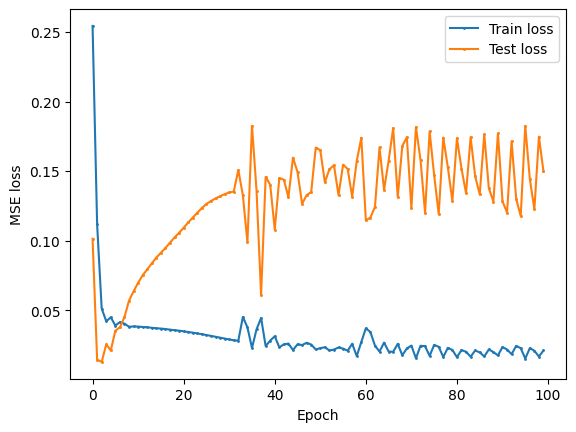

In [8]:
def loss_list():
    plt.plot(dast_model.train_loss_list, label='Train loss', marker='o', markersize=1)
    plt.plot(dast_model.test_loss_list, label='Test loss', marker='s', markersize=1)
    plt.xlabel('Epoch')
    plt.ylabel('MSE loss')
    plt.legend()
    plt.show()
loss_list()

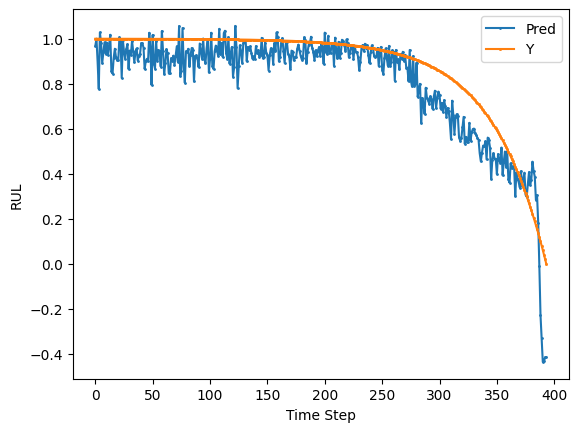

In [10]:
def best_predict():
    plt.plot(dast_model.best_predict, label='Pred', marker='o', markersize=1)
    plt.plot(y, label='Y', marker='s', markersize=1)
    plt.xlabel('Time Step')
    plt.ylabel('RUL')
    plt.legend()
    plt.show()
best_predict()

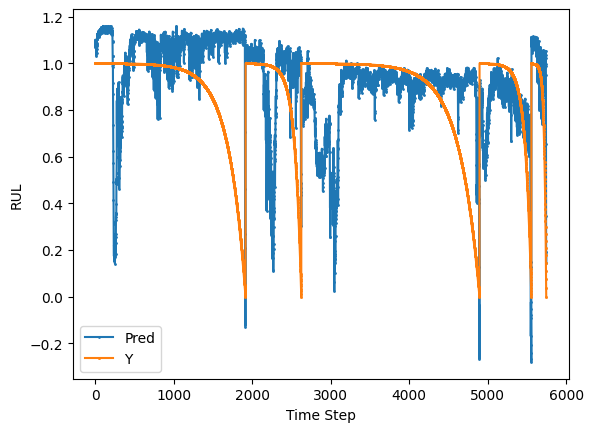

In [10]:
def last_predict_vs_y():
    last_predict_y = np.reshape(dast_model.last_predict_y, (-1))
    last_predict_y = last_predict_y.tolist()
    plt.plot(last_predict_y, label='Pred', marker='o', markersize=1)
    plt.plot(y, label='Y', marker='s', markersize=1)
    plt.xlabel('Time Step')
    plt.ylabel('RUL')
    plt.legend()
    plt.show()
last_predict_vs_y()

In [11]:
print(f"{dast_model.best_train_loss:.7f}")
print(f"{dast_model.best_mse_loss:.7f}")
print(f"{dast_model.best_rmse_loss:.7f}")

0.0095894
0.0499251
0.2234393


In [ ]:
# Run above